In [1]:
import heeps
from heeps.util.coord import mas2rms, disk_coord
from heeps.contrast.background import background
import astropy.units as u
from astropy.io import fits
import os.path
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline

### Offsets

nb offsets = 110


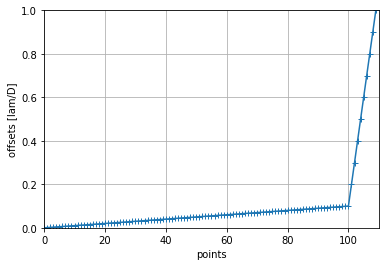

In [2]:
# up to 0.1 lam/D, step = 1/100
# up to 1 lam/D, step = 1/10
xy = np.append(np.arange(100)/1000, np.arange(1,11)/10)
print('nb offsets =', len(xy))
plt.plot(xy,'-+')
plt.xlim(0, len(xy))
plt.ylim(0, 1)
plt.xlabel('points')
plt.ylabel('offsets [lam/D]')
plt.grid(True), plt.grid(which='minor', linestyle=':');

### Select target

noffsets = 39


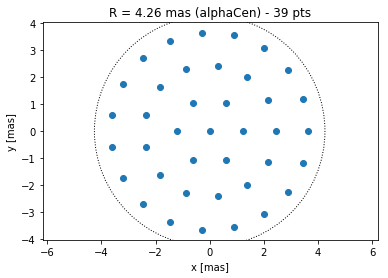

In [3]:
#target = ['point', 0]
target = ['alphaCen', 4.26] # mas
#target = ['pi1Gru', 9.18] # mas
name = target[0]
rstar = target[1]
diam_ext = 36.905
if name in ['alphaCen', 'pi1Gru']:
    fp_offsets_mas = disk_coord(rstar, nr=4)
    fp_offsets = mas2rms(fp_offsets_mas, diam_ext)
else:
    fp_offsets = None
# scatter plot
if fp_offsets is not None:
    print('noffsets = %s'%len(fp_offsets))
    plt.scatter(fp_offsets_mas[:,0], fp_offsets_mas[:,1])
    circ = plt.Circle((0,0), rstar, linestyle=':', color='k', Fill=False)
    ax = plt.gca()
    ax.add_artist(circ)
    ax.axis('equal')
    plt.xlabel('x [mas]')
    plt.ylabel('y [mas]')
    plt.title('R = %s mas (%s) - %s pts'%(rstar, name, len(fp_offsets)))

### Range of magnitudes

In [4]:
mag_min = 5
mag_max = 12
mags = np.arange(mag_min, mag_max+1) if fp_offsets is None else None
print('mags = %s'%mags)

mags = None


In [5]:
conf = dict(
    mode = 'CVC',
    file_pupil = 'pupil/ELT_fullM1.fits',
    file_phase = 'wavefront/cube_Cbasic_20201130_3600s_300ms_0piston_meters_scao_only_285.fits',
    file_point_err = 'wavefront/point_all_3600s_300ms.fits',
    add_phase = True,
    add_point_err = True,
    nframes = 2*len(xy),
    cube_duration = 2*len(xy)*0.3,
    fp_offsets = fp_offsets,
    )

In [6]:
def create_psfs(conf, case, mags=None, verbose=False):
    # update dir_output
    conf.update(dir_output=case)
    # initialize wavefront
    conf = heeps.config.read_config(verbose=False, **conf)
    conf = heeps.config.update_config(saveconf=True, verbose=verbose, **conf)
    wf = heeps.pupil.pupil(savefits=True, verbose=verbose, **conf)
    # load errors
    phase_screens, amp_screens, tiptilts, misaligns = heeps.wavefront.load_errors(verbose=verbose, **conf)
    # off-axis PSF
    psf = heeps.wavefront.propagate_one(wf, onaxis=False, savefits=True, verbose=verbose, **conf)
    # linear tiptilt
    lamD = conf['lam']/conf['diam_nominal']*u.rad.to('mas')
    xy_rms = mas2rms(xy*lamD, conf['diam_ext']) # converted to mas, then to rms
    tt = [(x,0) for x in xy_rms] + [(0,y) for y in xy_rms]
    # choose case
    print('\nCase = %s'%case)
    if 'linear_drift_only' in case:
        tiptilts = tt
        phase_screens = np.array([None]*conf['nframes'])
    elif 'scao_only' in case:
        tiptilts = np.array([None]*conf['nframes'])
    elif 'scao+linear_drift' in case:
        tiptilts = tt
    elif 'scao+random_drift' in case:
        pass
    # on-axis PSFs
    psfs = heeps.wavefront.propagate_cube(wf, phase_screens=phase_screens, \
        amp_screens=amp_screens, tiptilts=tiptilts, misaligns=misaligns, onaxis=True, \
        savefits=True, verbose=True, **conf)
    # add background
    if mags is not None:
        print('mag', end='')
        for conf['mag'] in mags:
            print(', %s'%conf['mag'], end='')
            psf_ON, psf_OFF = background(deepcopy(psfs), deepcopy(psf), **conf)
            fits.writeto(os.path.join(conf['dir_output'], 'onaxis_PSF_%s_%s_mag%s.fits'\
                %(conf['band'], conf['mode'], conf['mag'])), np.float32(psf_ON), overwrite=True)
            fits.writeto(os.path.join(conf['dir_output'], 'offaxis_PSF_%s_%s_mag%s.fits'\
                %(conf['band'], conf['mode'], conf['mag'])), np.float32(psf_OFF), overwrite=True)
        print('')

## L-band CVC

In [7]:
conf.update(
    band = 'L',
    file_lyot_stop = 'pupil/ls_LM_CVC_0.0291_0.08_0.0317_285.fits',
)
create_psfs(conf, '%s_%s/linear_drift_only'%(name, conf['band']), verbose=True)
if fp_offsets is None:
    create_psfs(conf, '%s_%s/scao_only'%(name, conf['band']), mags=mags)
    create_psfs(conf, '%s_%s/scao+linear_drift'%(name, conf['band']), mags=mags)
    create_psfs(conf, '%s_%s/scao+random_drift'%(name, conf['band']), mags=mags)

Simulation config: band=L, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, beam_ratio=0.2568
   npupil=285, pscale=5.47 mas, lam=3.8112E-06 m
   hfov=1.1 arcsec (-> ndet=403, 51.74 lam/D)

Load pupil from 'ELT_fullM1.fits'
Load phase screens from 'cube_Cbasic_20201130_3600s_300ms_0piston_meters_scao_only_285.fits'
   nscreens=220 (nframes=220, nstep=1)
Load pointing errors from 'point_all_3600s_300ms.fits'
   nscreens=220
Create single off-axis PSF

Case = alphaCen_L/linear_drift_only
Create on-axis PSF cube
   2021-06-13 12:02:08, e2e simulation using 56 cores
   expected time to complete: 222.06 seconds
   2021-06-13 13:10:17, completed in 4144.1 seconds


## N2-band CVC

In [8]:
conf.update(
    band = 'N2',
    file_lyot_stop = 'pupil/ls_N_CVC_0.0356_0.08_0.0383_119.fits',
)
create_psfs(conf, '%s_%s/linear_drift_only'%(name, conf['band']), verbose=True)
if fp_offsets is None:
    create_psfs(conf, '%s_%s/scao_only'%(name, conf['band']), mags=mags)
    create_psfs(conf, '%s_%s/scao+linear_drift'%(name, conf['band']), mags=mags)
    create_psfs(conf, '%s_%s/scao+random_drift'%(name, conf['band']), mags=mags)

Simulation config: band=N2, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, beam_ratio=0.1072
   npupil=119, pscale=6.79 mas, lam=1.1330E-05 m
   hfov=1.1 arcsec (-> ndet=325, 17.42 lam/D)

Load pupil from 'ELT_fullM1.fits'
Load phase screens from 'cube_Cbasic_20201130_3600s_300ms_0piston_meters_scao_only_285.fits'
   nscreens=220 (nframes=220, nstep=1)
Load pointing errors from 'point_all_3600s_300ms.fits'
   nscreens=220
Create single off-axis PSF

Case = alphaCen_N2/linear_drift_only
Create on-axis PSF cube
   2021-06-13 13:11:45, e2e simulation using 56 cores
   expected time to complete: 233.04 seconds
   2021-06-13 14:18:26, completed in 4059.24 seconds
